# Time series forecasting

This tutorial uses safeds on **US inflation rates data** to predict future inflation with a recurrent neural network. The **US inflation rates data** is a time series. A time series, is a series with frequently measured values. This time series measures the inflation of the US every Month from January 1947 until June 2023.


1. Load your data into a `Table`. The data is available under `docs/tutorials/data/US_Inflation_rates.csv`:


In [21]:
from safeds.data.tabular.containers import Table

inflation = Table.from_csv_file("data/US_Inflation_rates.csv")
# For visualisation purposes we only print out the first 15 rows.
inflation.slice_rows(0,15)

date,value
str,f64
"""1947-01-01""",21.48
"""1947-02-01""",21.62
"""1947-03-01""",22.0
"""1947-04-01""",22.0
"""1947-05-01""",21.95
…,…
"""1947-11-01""",23.06
"""1947-12-01""",23.41
"""1948-01-01""",23.68


This dataset contains two columns: date and value. The date column is right now still a string type with a format like this: "Year-Month-Day". We can convert it into a temporal type column like this:

In [22]:
inflation = inflation.replace_column("date", [inflation.get_column("date").transform(lambda cell:cell.str.to_date())])
inflation.slice_rows(0,15)

date,value
date,f64
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.0
1947-04-01,22.0
1947-05-01,21.95
…,…
1947-11-01,23.06
1947-12-01,23.41
1948-01-01,23.68


Let's have a look on the dataset.

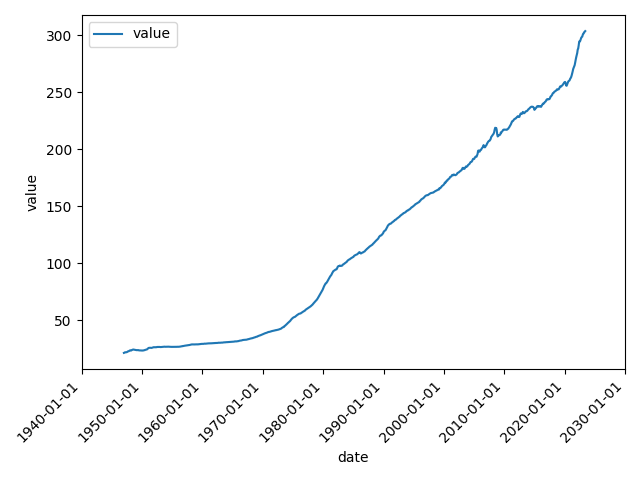

In [23]:
inflation.plot.line_plot(x_name="date", y_names=["value"])

2. In the second step we prepare the data, to train our neural network. For that we need to normalize our data, because neural networks work better on small values. After that, we split the data into a training and test set.


In [24]:
from safeds.data.tabular.transformation import StandardScaler

scaler = StandardScaler()
trained_scaler, inflation_scaled = scaler.fit_and_transform(inflation)
train_set, test_set = inflation_scaled.split_rows(percentage_in_first=0.9, shuffle=False)

3. After the data preparation we can start defining our neural network. We do this by defining the different layers and their output size.

In [25]:
from safeds.ml.nn import NeuralNetworkRegressor

from safeds.ml.nn.converters import (
    InputConversionTimeSeries,
)
from safeds.ml.nn.layers import (
    ForwardLayer,
    LSTMLayer,
)

neural_network = NeuralNetworkRegressor(
    InputConversionTimeSeries(),
    [ForwardLayer(256), LSTMLayer(128), ForwardLayer(1)],
)

4. When working with time series data, the data is segmented into windows prior to being fed into the neural network. Each window consists of a sequence of consecutive data points. Windowing data is beneficial for neural networks as it allows them to more effectively learn the relationships between data points. In Safe-DS, the windowing step is automated; users simply need to classify their dataset as a time series, as demonstrated below.

In [26]:
fitted_neural_network = neural_network.fit(train_set.to_time_series_dataset(
    target_name="value",
    window_size=12,
    forecast_horizon=1,
    continuous=False,
    extra_names= ["date"]
), epoch_size=10)

5. Now that we defined and trained our model, we can start making predictions.

In [27]:

prediction = fitted_neural_network.predict(
    test_set.to_time_series_dataset(
        target_name="value",
        window_size=10,
        forecast_horizon=1,
        continuous=False,
        extra_names= ["date"]
    )
)
prediction = prediction.to_table()

6. Now we only need to inverse our predictions and we can start visualizing them:


In [28]:
prediction = trained_scaler.inverse_transform(prediction)
test_set = trained_scaler.inverse_transform(test_set)


In [29]:
preds_with_test = prediction.add_columns([test_set.slice_rows(13).rename_column("value","true_value").get_column("true_value")])

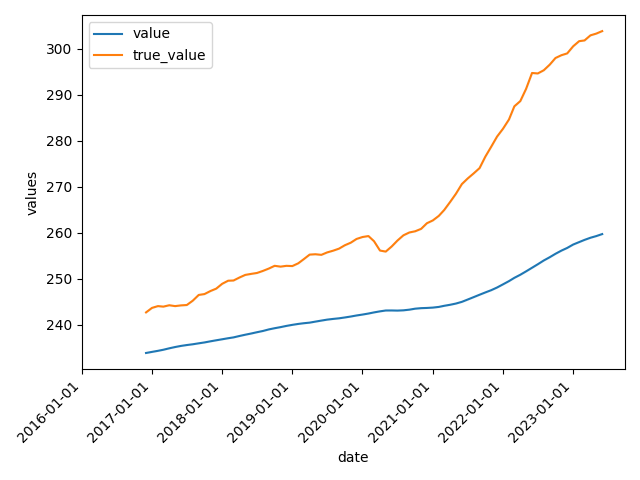

In [30]:
preds_with_test.plot.line_plot("date", ["value", "true_value"])